# maxvogt-analysis: Feldbach

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [FB023](https://mtwente.github.io/maxvogt/items/fb023.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Ffeldbach.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Hombrechtikon'
point = 47.23927, 8.78385
address = 'Bahnhofstrasse 16, 8714 Feldbach'
dist = 2000
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(address).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
#buildings = osmnx.features.features_from_place(place, tags={'building':True})
#buildings = osmnx.features.features_from_address(address, tags={'building':True}, dist=dist)
buildings = osmnx.features.features_from_point(point, tags={'building':True}, dist=dist)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [5]:
buildings

addr:city addr:country addr:postcode  \
element_type osmid                                                   
node         11788372868  Hombrechtikon           CH          8634   
             11788398769  Hombrechtikon           CH          8634   
             11788398770  Hombrechtikon           CH          8634   
             11788398771  Hombrechtikon           CH          8634   
             11788398772  Hombrechtikon           CH          8634   
...                                 ...          ...           ...   
way          1279666737             NaN          NaN           NaN   
             1292789241      Wolfhausen          NaN          8633   
             1292789243      Wolfhausen          NaN          8633   
             1302337540             NaN          NaN           NaN   
relation     3988119                NaN          NaN           NaN   

                               addr:street  \
element_type osmid                           
node         11788372868  Richttannstrasse   
             11788398769  Richttannstrasse   
             11788398770  Richttannstrasse   
             11788398771  Richttannstrasse   
             11788398772  Richttannstrasse   
...                                    ...   
way          1279666737                NaN   
             1292789241        Bachstrasse   
             1292789243      Sunnenbergweg   
             1302337540                NaN   
relation     3988119                   NaN   

                                                                   geometry  \
element_type osmid                                                            
node         11788372868                           POINT (8.78107 47.25653)   
             11788398769                           POINT (8.78104 47.25638)   
             11788398770                           POINT (8.78102 47.25623)   
             11788398771                           POINT (8.78123 47.25630)   
             11788398772                           POINT (8.78127 47.25648)   
...                                                                     ...   
way          1279666737   POLYGON ((8.78341 47.23920, 8.78341 47.23921, ...   
             1292789241   POLYGON ((8.79487 47.25559, 8.79481 47.25546, ...   
             1292789243   POLYGON ((8.80202 47.25623, 8.80202 47.25622, ...   
             1302337540   POLYGON ((8.77538 47.24756, 8.77544 47.24759, ...   
relation     3988119      POLYGON ((8.75695 47.24331, 8.75700 47.24332, ...   

                         addr:housenumber      name      amenity check_date  \
element_type osmid                                                            
node         11788372868              17a       NaN          NaN        NaN   
             11788398769              17c       NaN          NaN        NaN   
             11788398770              17e       NaN          NaN        NaN   
             11788398771              17d       NaN          NaN        NaN   
             11788398772              17b       NaN          NaN        NaN   
...                                   ...       ...          ...        ...   
way          1279666737               NaN       NaN          NaN        NaN   
             1292789241                1b       NaN          NaN        NaN   
             1292789243                6c  Ludothek  toy_library        NaN   
             1302337540               NaN       NaN          NaN        NaN   
relation     3988119                  NaN       NaN          NaN        NaN   

                         opening_hours  ... landuse shelter_type  fee  \
element_type osmid                      ...                             
node         11788372868           NaN  ...     NaN          NaN  NaN   
             11788398769           NaN  ...     NaN          NaN  NaN   
             11788398770           NaN  ...     NaN          NaN  NaN   
             11788398771           NaN  ...     NaN          NaN  NaN   
             11788398772  

In [6]:
buildings.geom_type.value_counts()

Polygon    3268
Point         5
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

geometry   uID
0     POLYGON ((2700792.775 1234644.065, 2700787.029...     0
1     POLYGON ((2700878.775 1234643.302, 2700886.588...     1
2     POLYGON ((2700832.914 1234669.955, 2700834.003...     2
3     POLYGON ((2700832.622 1234699.183, 2700860.864...     3
4     POLYGON ((2700878.707 1234693.227, 2700874.023...     4
...                                                 ...   ...
3263  POLYGON ((2701818.736 1232903.118, 2701818.179...  3263
3264  POLYGON ((2702654.491 1234739.627, 2702650.608...  3264
3265  POLYGON ((2703194.703 1234820.278, 2703194.248...  3265
3266  POLYGON ((2701194.560 1233821.789, 2701199.075...  3266
3267  POLYGON ((2699807.659 1233326.448, 2699811.189...  3267

[3268 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [11]:
#osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)
#osm_graph = osmnx.graph_from_address(place, network_type='drive', truncate_by_edge=True, dist=dist)
osm_graph = osmnx.graph_from_point(point, network_type='drive', truncate_by_edge=True, dist=dist)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [12]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [13]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [14]:
streets.explore()

In [15]:
streets

osmid  \
u           v           key                                                
2114011     371575044   0                                       32985228   
            1032285810  0    [27454813, 27454812, 139668861, 1304695951]   
            371575052   0                                      139668861   
371575044   2114011     0                                       32985228   
1032285810  2114011     0    [139668861, 27454812, 27454813, 1304695951]   
...                                                                  ...   
9524984347  9572202192  0                                     1039508456   
10108135108 10108135110 0                                     1104611411   
10108155023 10108155025 0                                     1104611427   
10108155044 10108155045 0                                     1104611431   
10605539793 10605539792 0                                     1137768728   

                                                     name      highway  \
u           v           key                                              
2114011     371575044   0              Fuchsenbergstrasse  residential   
            1032285810  0    [Zürcherstrasse, Seestrasse]      primary   
            371575052   0                  Zürcherstrasse      primary   
371575044   2114011     0              Fuchsenbergstrasse  residential   
1032285810  2114011     0    [Seestrasse, Zürcherstrasse]      primary   
...                                                   ...          ...   
9524984347  9572202192  0                       Sunnebach  residential   
10108135108 10108135110 0                             Tal  residential   
10108155023 10108155025 0                         Sandhof  residential   
10108155044 10108155045 0                         Neuhaus  residential   
10605539793 10605539792 0                             NaN  residential   

                             oneway reversed    length  \
u           v           key                              
2114011     371575044   0     False    False   213.072   
            1032285810  0     False    False  1450.631   
            371575052   0     False     True   145.840   
371575044   2114011     0     False     True   213.072   
1032285810  2114011     0     False     True  1450.631   
...                             ...      ...       ...   
9524984347  9572202192  0     False     True   114.458   
10108135108 10108135110 0     False     True    38.889   
10108155023 10108155025 0     False     True    14.134   
10108155044 10108155045 0     False     True    34.149   
10605539793 10605539792 0     False     True    10.522   

                                                                      geometry  \
u           v           key                                                      
2114011     371575044   0    LINESTRING (2703568.100 1232962.929, 2703562.5...   
            1032285810  0    LINESTRING (2703568.100 1232962.929, 2703477.2...   
            371575052   0    LINESTRING (2703568.100 1232962.929, 2703601.7...   
371575044   2114011     0    LINESTRING (2703649.323 1232905.412, 2703603.6...   
1032285810  2114011     0    LINESTRING (2702160.366 1232963.258, 2702169.4...   
...                                                                        ...   
9524984347  9572202192  0    LINESTRING (2700885.988 1233723.948, 2700893.1...   
10108135108 10108135110 0    LINESTRING (2702741.637 1233330.774, 2702762.2...   
10108155023 10108155025 0    LINESTRING (2702158.830 1233432.972, 2702167.7...   
10108155044 10108155045 0    LINESTRING (2699928.511 1234508.624, 2699941.2...   
10605539793 10605539792 0    LINESTRING (2703616.227 1233047.942, 2703615.7...   

                            lanes  ref      maxspeed junction bridge tunnel  \
u           v           key                                                   
2114011     371575044   0     NaN  NaN           NaN      NaN    NaN    NaN   
            1032285810  0       2   17  [50, 80, 60]    

In [16]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [17]:
streets

geometry  nID
0    LINESTRING (2703568.100 1232962.929, 2703477.2...    0
1    LINESTRING (2703568.100 1232962.929, 2703601.7...    1
2    LINESTRING (2702160.366 1232963.258, 2702169.4...    2
3    LINESTRING (2702160.366 1232963.258, 2702150.8...    3
4    LINESTRING (2703708.805 1232924.697, 2703709.4...    4
..                                                 ...  ...
664  LINESTRING (2703615.779 1233058.453, 2703616.2...  664
665  LINESTRING (2703587.436 1234852.469, 2703608.7...  665
666  LINESTRING (2703651.551 1234564.435, 2703646.0...  666
667  LINESTRING (2703708.805 1232924.697, 2703718.4...  667
668  LINESTRING (2704053.903 1233322.850, 2704047.1...  668

[669 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [18]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [19]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [20]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2700792.775 1234644.065, 2700787.029...     0        300.0   
0     POLYGON ((2700792.775 1234644.065, 2700787.029...     0        295.0   
1     POLYGON ((2700878.775 1234643.302, 2700886.588...     1        300.0   
2     POLYGON ((2700832.914 1234669.955, 2700834.003...     2        598.0   
3     POLYGON ((2700832.622 1234699.183, 2700860.864...     3        598.0   
...                                                 ...   ...          ...   
3264  POLYGON ((2702654.491 1234739.627, 2702650.608...  3264        651.0   
3265  POLYGON ((2703194.703 1234820.278, 2703194.248...  3265        519.0   
3265  POLYGON ((2703194.703 1234820.278, 2703194.248...  3265        516.0   
3266  POLYGON ((2701194.560 1233821.789, 2701199.075...  3266        608.0   
3267  POLYGON ((2699807.659 1233326.448, 2699811.189...  3267        574.0   

        nID  
0     300.0  
0     295.0  
1     300.0  
2     598.0  
3     598.0  
...     ...  
3264  651.0  
3265  519.0  
3265  516.0  
3266  608.0  
3267  574.0  

[4716 rows x 4 columns]

In [21]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [22]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [23]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [24]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [25]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [26]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [27]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


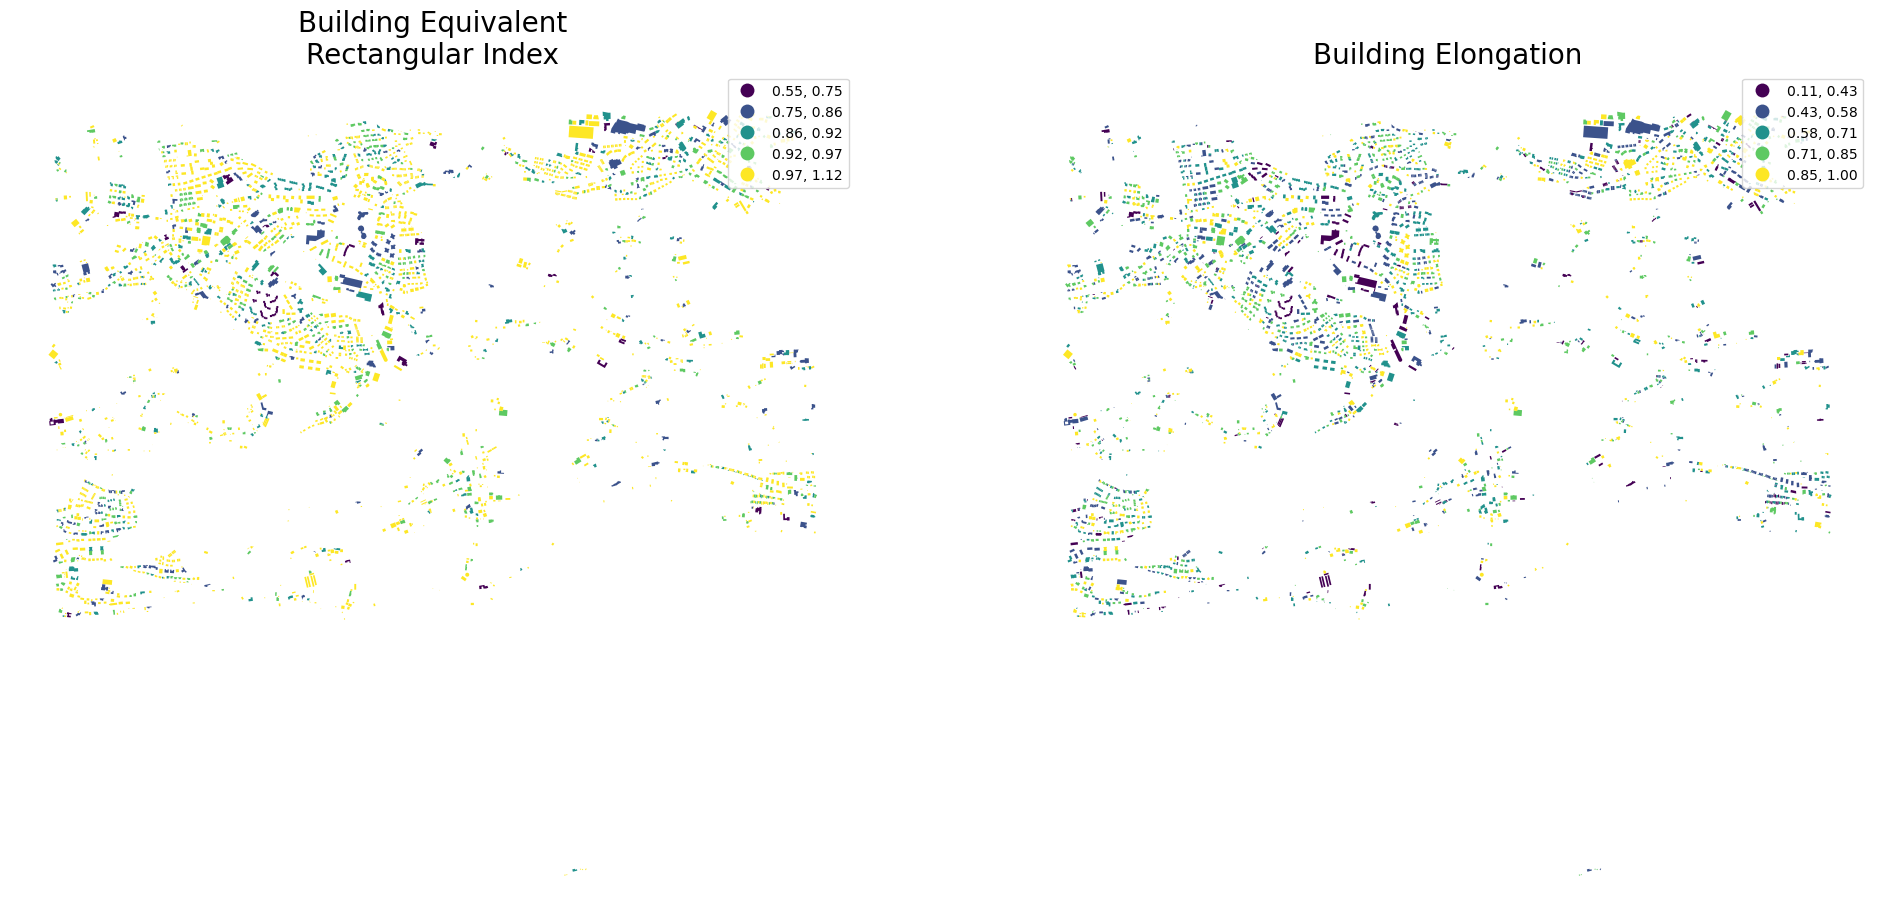

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Feldbach/eri_and_elongation.pdf')  

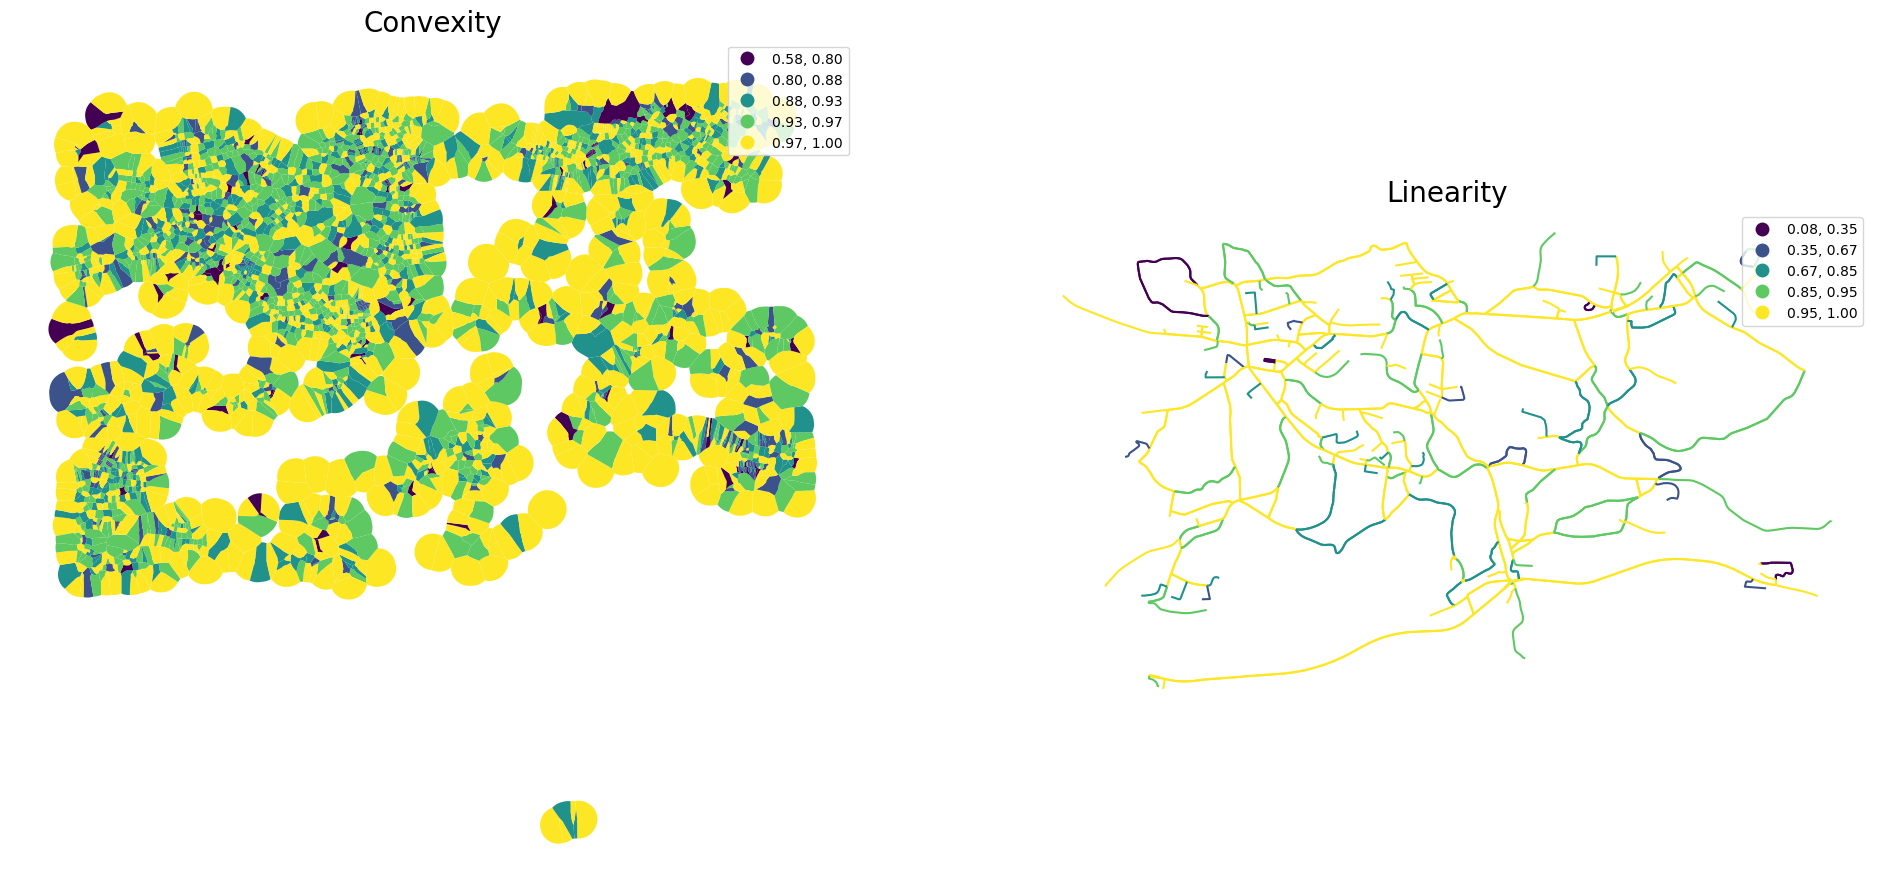

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Feldbach/convexity_and_linearity.pdf')  

### Spatial distribution

In [30]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


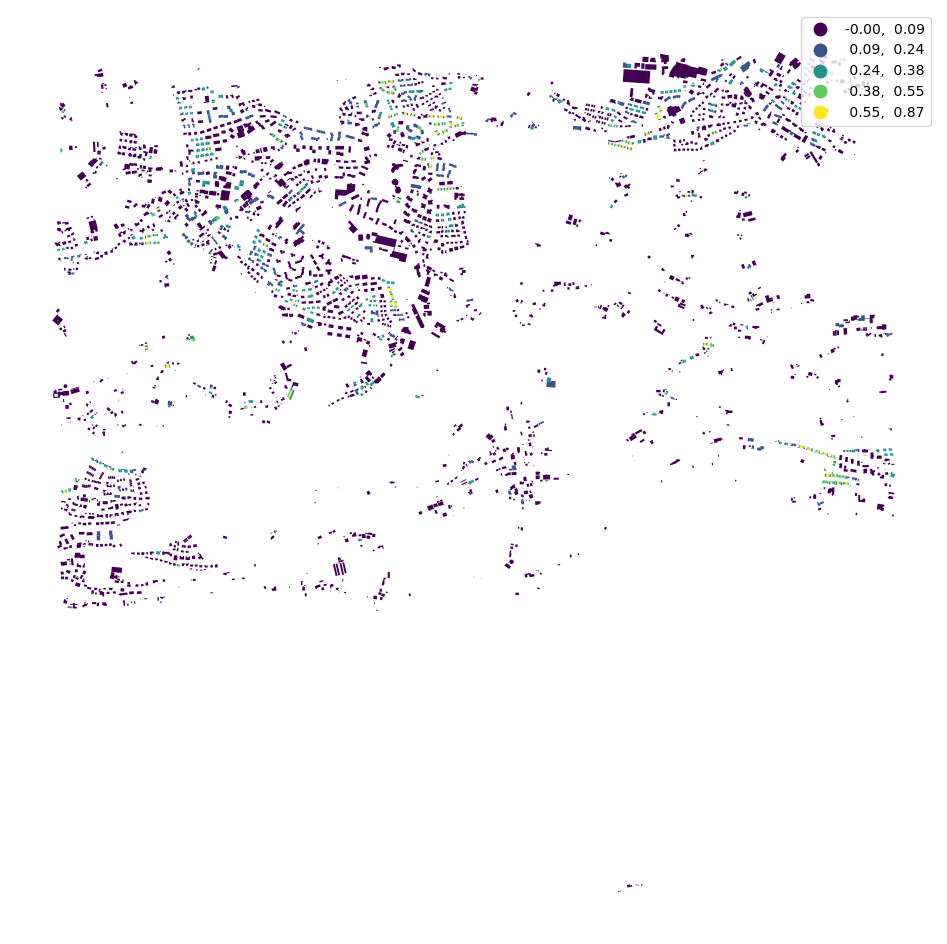

In [31]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Feldbach/sharedwalls.pdf')  

Generate spatial weights matrix using `libpysal`.

In [32]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [33]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


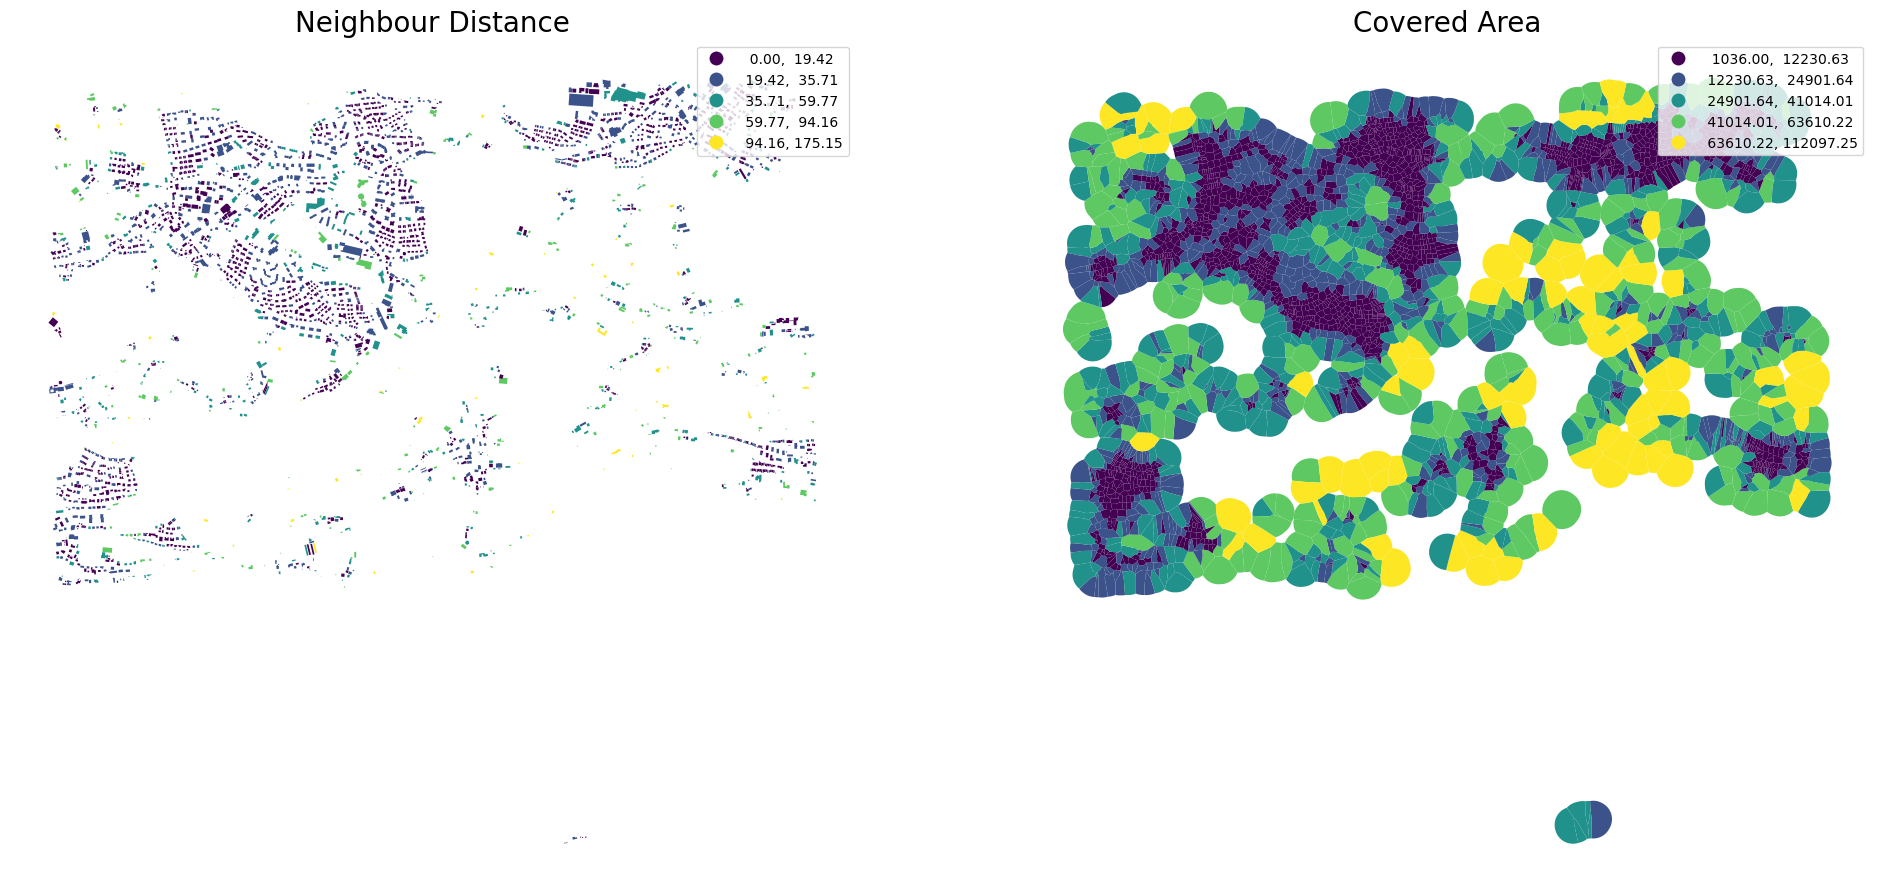

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Feldbach/neighbourdist_and_coveredarea.pdf')  

In [35]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [36]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [37]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


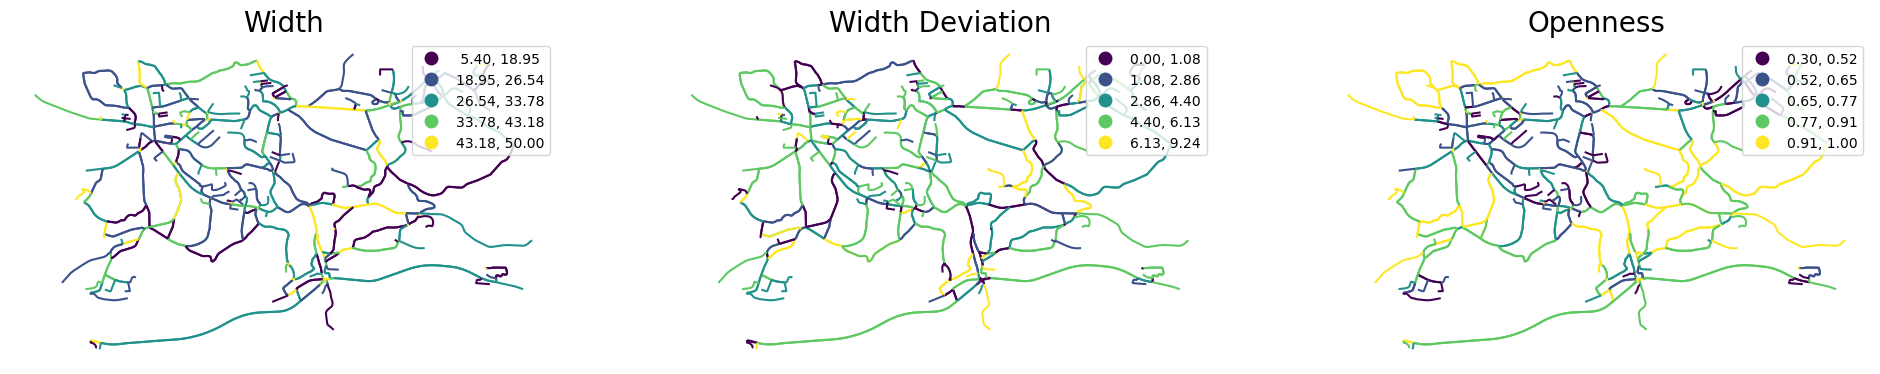

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Feldbach/road_network.pdf')  

### Intensity

In [39]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


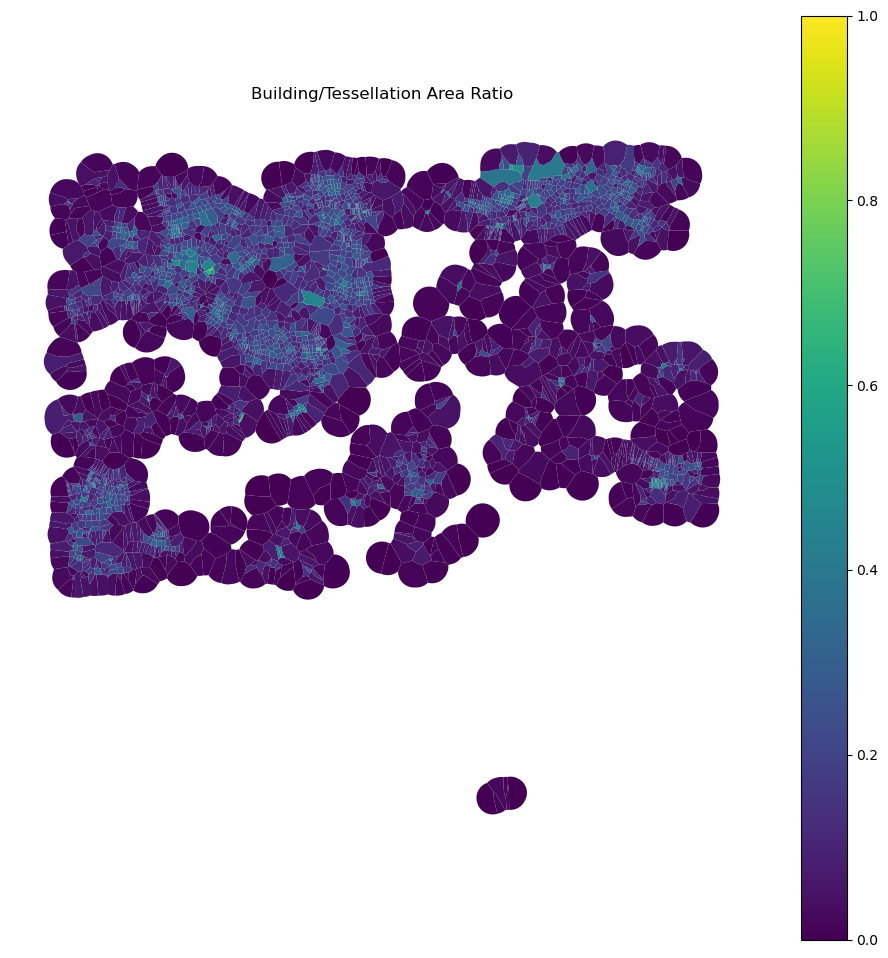

In [40]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Feldbach/tessellation_ratio.pdf')  

### Connectivity

In [41]:
graph = momepy.gdf_to_nx(streets)

In [42]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [43]:
nodes, streets = momepy.nx_to_gdf(graph)

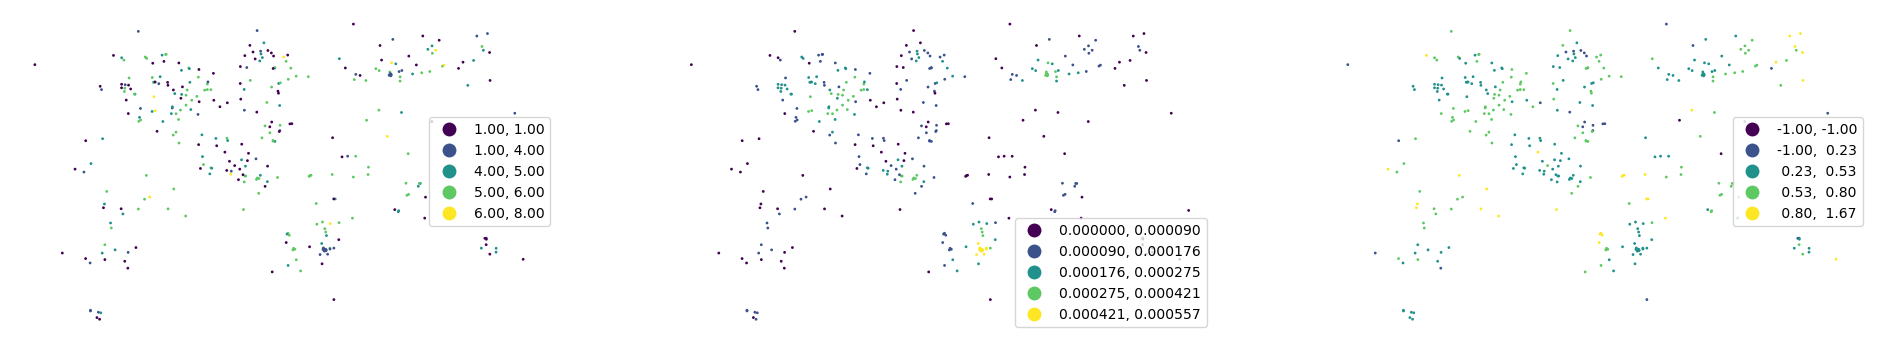

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Feldbach/connectivity.pdf')  

In [45]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/3268 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [46]:
tessellation

uID                                           geometry    nID  \
0     3095  POLYGON ((2702638.914 1230938.900, 2702638.763...    NaN   
1     3247  POLYGON ((2703785.843 1232664.354, 2703787.366...  667.0   
2     1970  POLYGON ((2703613.627 1232709.840, 2703614.767...  566.0   
3     3244  POLYGON ((2703742.203 1232725.051, 2703741.876...  667.0   
4     3245  POLYGON ((2703837.021 1232797.495, 2703836.108...  667.0   
...    ...                                                ...    ...   
3263   526  POLYGON ((2701546.663 1234863.002, 2701545.636...  356.0   
3264  2915  POLYGON ((2701835.952 1234860.984, 2701835.743...  637.0   
3265   557  POLYGON ((2701742.261 1234855.356, 2701740.203...  637.0   
3266   527  POLYGON ((2701436.395 1234875.357, 2701435.262...  620.0   
3267   539  POLYGON ((2701464.031 1234906.182, 2701463.695...  620.0   

              area  convexity  neighbors  covered_area       car  
0     19381.412152   0.982674   0.003562  24515.266632  0.002069  
1     19618.167069   0.995335   0.003748  38120.768675  0.004076  
2     17271.757718   0.993893   0.010118  61832.322209  0.004827  
3     12161.574008   0.962994   0.010827  66390.587268  0.075841  
4      6341.027598   0.957784   0.010032  48632.064511  0.047893  
...            ...        ...        ...           ...       ...  
3263   7784.031108   0.981132   0.016834  25782.205839  0.022981  
3264   6076.846798   0.996447   0.012347  24666.758966  0.003700  
3265   7297.799962   0.986392   0.011521  18443.854955  0.013412  
3266   3114.904983   0.864932   0.009463  17705.660169  0.084793  
3267   9599.274165   0.985126   0.010226  22982.036131  0.021836  

[3268 rows x 8 columns]

In [47]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [48]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [49]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_74964/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [50]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [51]:
percentiles_joined

area_x_25    area_x_50     area_x_75  convexity_25  convexity_50  \
0     3670.950114  8220.447746  14800.676450      0.952090      0.983101   
1     2977.481088  6586.976249  10218.069701      0.933160      0.964596   
2      321.585812   909.570160   3245.176074      0.848060      0.895136   
3      830.254915  1638.271008   6341.027598      0.870355      0.949045   
4     1551.470938  3357.417909   7621.744117      0.918397      0.962994   
...           ...          ...           ...           ...           ...   
3263   548.066467   794.022372   1541.622059      0.925427      0.971227   
3264  1538.037551  2713.377427   6889.995243      0.951274      0.968204   
3265  1151.142767  1557.877081   4419.743170      0.958271      0.977700   
3266   500.838199   675.642486   2493.713655      0.872534      0.948934   
3267   515.827128   629.359461   1670.117087      0.900025      0.960425   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.986413      0.004847      0.006656      0.007993     34094.145938   
1         0.989908      0.010075      0.018642      0.031125     23475.253714   
2         0.971374      0.026477      0.039647      0.056468      4054.885452   
3         0.976454      0.015804      0.033859      0.046029      9926.206956   
4         0.987814      0.011055      0.027627      0.038335     13427.751908   
...            ...           ...           ...           ...              ...   
3263      0.981734      0.031745      0.048711      0.059822      4184.385279   
3264      0.985910      0.015942      0.023926      0.030706     24283.026546   
3265      0.985561      0.018971      0.028673      0.039781     11719.967022   
3266      0.979833      0.025824      0.040616      0.057841      4603.097193   
3267      0.981132      0.033070      0.046856      0.060536      4506.143941   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...           NaN        NaN        NaN        NaN           NaN   
1     ...  1.232925e+06        1.0        1.0        5.0      0.000021   
2     ...  1.232963e+06        1.0        5.0        5.0      0.000028   
3     ...  1.232962e+06        1.0        5.0        5.0      0.000028   
4     ...  1.232925e+06        1.0        5.0        5.0      0.000024   
...   ...           ...        ...        ...        ...           ...   
3263  ...  1.234851e+06        1.0        4.0        5.0      0.000126   
3264  ...  1.234807e+06        1.0        1.0        6.0      0.000131   
3265  ...  1.234807e+06        1.0        1.0        6.0      0.000131   
3266  ...  1.234875e+06        1.0        4.0        5.0      0.000074   
3267  ...  1.234851e+06        1.0        4.0        5.0      0.000135   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0              NaN           NaN            NaN            NaN            NaN  
1         0.000028      0.000078       0.285714       0.666667       1.000000  
2         0.000058      0.000058       0.400000       0.400000       0.666667  
3         0.000058      0.000078       0.285714       0.400000       0.666667  
4         0.000078      0.000078       0.285714       0.285714       0.833333  
...            ...           ...            ...            ...            ...  
3263      0.000149      0.000208       0.230769       0.248718       0.444444  
3264      0.000131      0.000132       0.600000       0.705882       0.705882  
3265      0.000131      0.000167       0.608696       0.705882       0.705882  
3266      0.000146      0.000217       0.230769       0.266667       0.444444  
3267      0.000146      0.000217       0.230769       0.230769       0.444444  

[3268 rows x 66 columns]

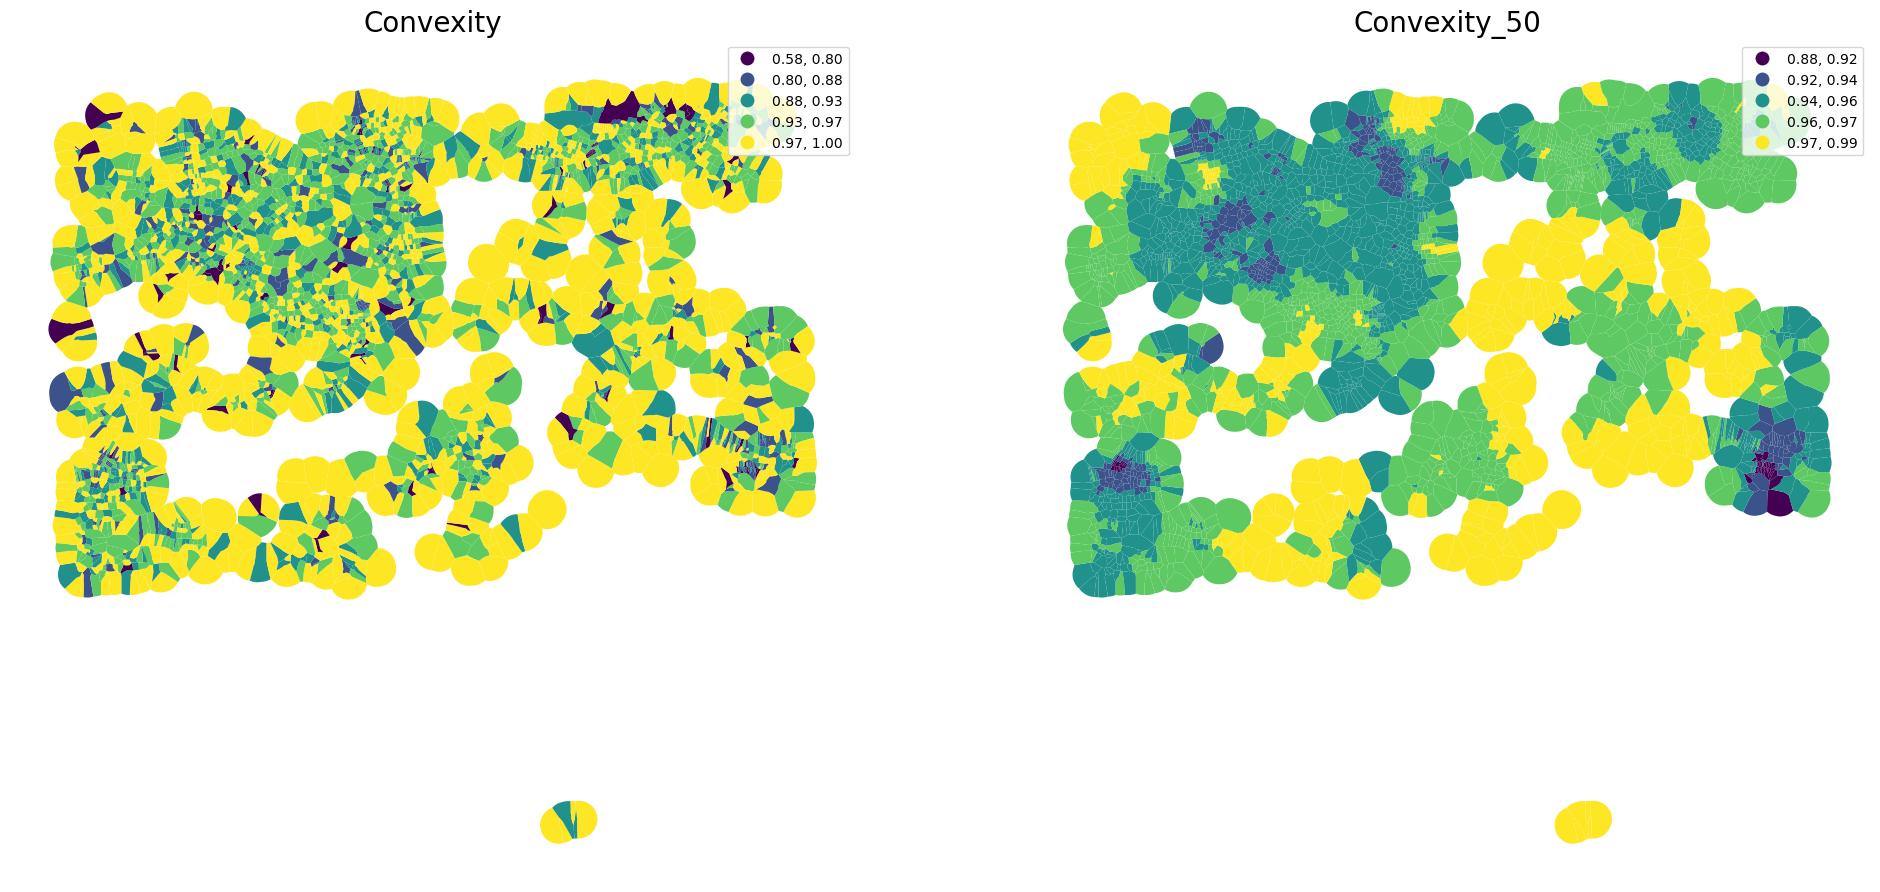

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Feldbach/convexity.pdf')  

## Clustering

Standardize values before clustering.

In [53]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [54]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0      3.174493   3.673355   3.584328      1.214517      1.924370   
1      2.366900   2.734161   2.123325      0.352326      0.556726   
2     -0.726076  -0.530165  -0.099736     -3.523610     -4.576743   
3     -0.133695  -0.111185   0.887267     -2.508152     -0.592572   
4      0.706211   0.877269   1.295578     -0.320053      0.438343   
...         ...        ...        ...           ...           ...   
3263  -0.462323  -0.596601  -0.642855      0.000136      1.046859   
3264   0.690567   0.506966   1.062286      1.177363      0.823378   
3265   0.240001  -0.157409   0.274733      1.496010      1.525185   
3266  -0.517324  -0.664666  -0.339314     -2.408895     -0.600729   
3267  -0.499868  -0.691277  -0.601888     -1.156834      0.248518   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         1.043355     -2.202670     -2.618353     -3.099643         2.810496   
1         1.450286     -1.711602     -1.614691     -1.341067         1.538207   
2        -0.707397     -0.170891      0.144342      0.585553        -0.788620   
3        -0.115995     -1.173436     -0.340392     -0.208032        -0.085155   
4         1.206451     -1.619554     -0.862284     -0.793005         0.334378   
...            ...           ...           ...           ...              ...   
3263      0.498644      0.323911      0.903330      0.840521        -0.773104   
3264      0.984859     -1.160519     -1.172155     -1.372919         1.634989   
3265      0.944187     -0.876000     -0.774691     -0.683047         0.129762   
3266      0.277420     -0.232250      0.225442      0.689980        -0.722936   
3267      0.428623      0.448436      0.747974      0.894851        -0.734553   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...       NaN        NaN        NaN        NaN           NaN   
1     ... -1.407410  -1.255869  -2.629757  -0.464333     -1.193612   
2     ... -1.355739  -1.255869   0.149867  -0.464333     -1.094147   
3     ... -1.357602  -1.255869   0.149867  -0.464333     -1.094147   
4     ... -1.407410  -1.255869   0.149867  -0.464333     -1.143879   
...   ...       ...        ...        ...        ...           ...   
3263  ...  1.195539  -1.255869  -0.545039  -0.464333      0.327957   
3264  ...  1.136214  -1.255869  -2.629757   0.515075      0.407510   
3265  ...  1.136214  -1.255869  -2.629757   0.515075      0.407510   
3266  ...  1.228345  -1.255869  -0.545039  -0.464333     -0.419721   
3267  ...  1.195539  -1.255869  -0.545039  -0.464333      0.463529   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0              NaN           NaN            NaN            NaN            NaN  
1        -1.327198     -0.941679      -0.398931       0.600925       1.652103  
2        -0.959996     -1.164175      -0.038120      -0.338398       0.326464  
3        -0.959996     -0.941679      -0.398931      -0.338398       0.326464  
4        -0.703973     -0.941679      -0.398931      -0.740966       0.989284  
...            ...           ...            ...            ...            ...  
3263      0.157586      0.439817      -0.572398      -0.871284      -0.557294  
3264     -0.054528     -0.369850       0.593298       0.739061       0.482422  
3265     -0.054528      0.000865       0.620751       0.739061       0.482422  
3266      0.124969      0.530619      -0.572398      -0.808060      -0.557294  
3267      0.124969      0.530619      -0.572398      -0.934508      -0.557294  

[3268 rows x 66 columns]

### How many clusters?

In [55]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.025 seconds.
K=3 fitted in 0.038 seconds.
K=4 fitted in 0.044 seconds.
K=5 fitted in 0.059 seconds.
K=6 fitted in 0.066 seconds.
K=7 fitted in 0.078 seconds.
K=8 fitted in 0.066 seconds.
K=9 fitted in 0.093 seconds.
K=10 fitted in 0.085 seconds.
K=11 fitted in 0.095 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [56]:
show(cgram.bokeh())

In [57]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   2   1   3   2   3   1   1   7   5
1   0   1   2   1   3   4   2   6   4   7   8
2   0   0   1   0   2   0   0   0   8   1   6
3   0   0   1   0   2   0   0   0   8   1   1
4   0   1   2   2   0   2   3   1   1   6   1

In [58]:
merged["cluster"] = cgram.labels[8].values

In [59]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [60]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [61]:
urban_types.to_file('../data/raw/Feldbach.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [62]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [63]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>